In [1]:
from fastai import *
from fastai.vision import *
import torch.onnx
from torch.autograd import Variable
import os
from torch.optim import *

os.environ["TORCH_HOME"] = "/media/subhaditya/DATA/COSMO/Datasets-Useful"

# EfficientNet

In [4]:
path = Path("/media/subhaditya/DATA/COSMO/Datasets/leapgestrecog/leapGestRecog")

In [12]:
def lab(x):
    return str(x).split('_')[-2]

In [13]:
data = (
    (
        ImageList.from_folder(path)
        .split_by_rand_pct()
        .label_from_func(lab)
        .transform(get_transforms(), size=128)
    )
    .databunch(bs=64)
    .normalize(imagenet_stats)
)

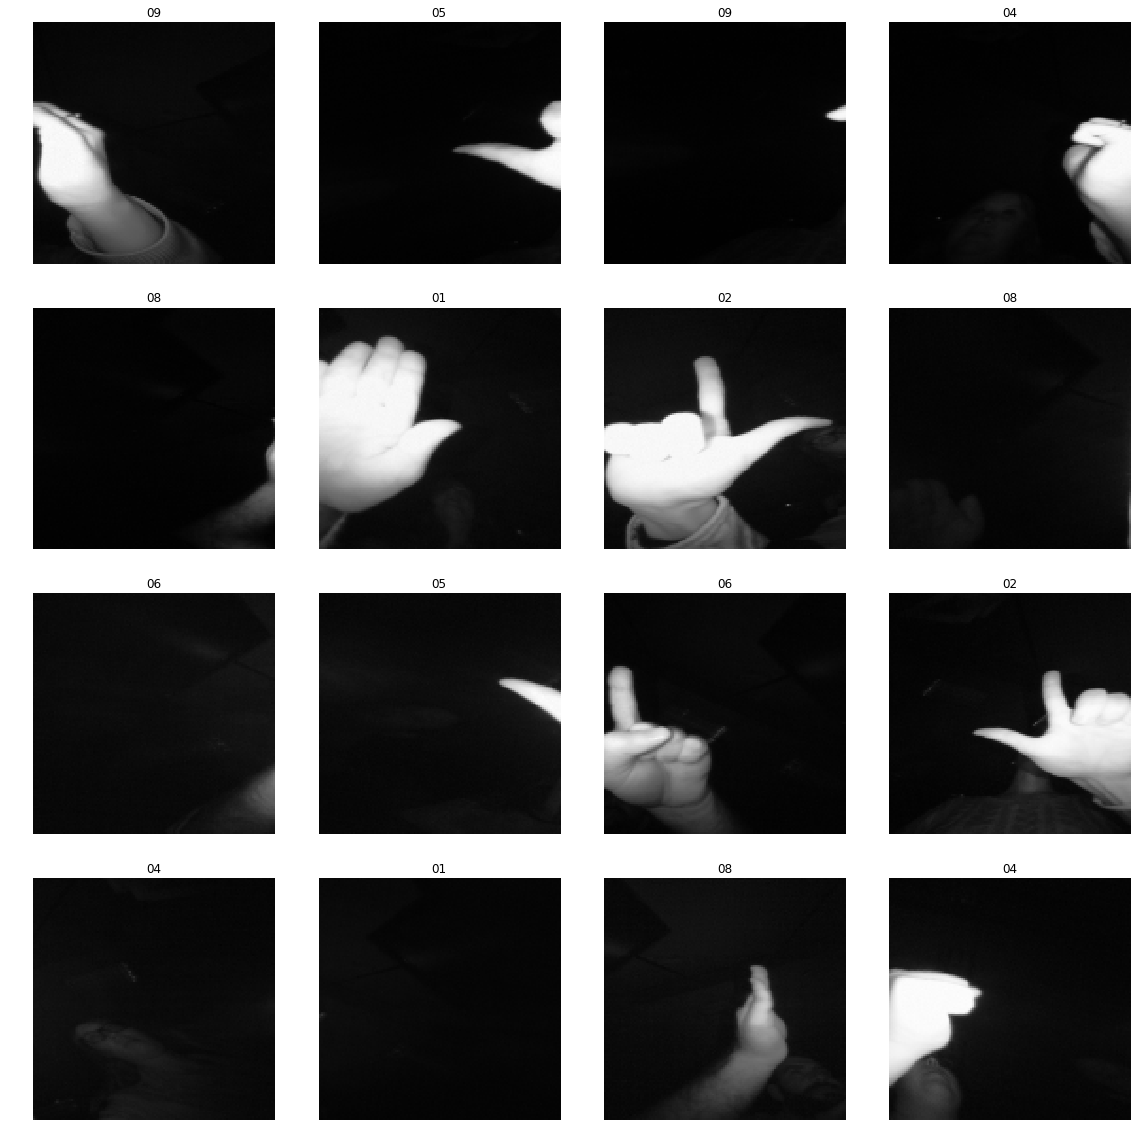

In [14]:
data.show_batch(4)

(array([1575., 1591., 1590., 1620., 1613., 1581., 1593., 1617., 1613., 1607.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

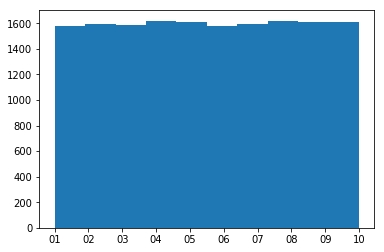

In [21]:
class_sam = [str(x) for x in data.train_ds.y]
plt.hist(class_sam)

In [15]:
data.c

10

In [16]:
labels = ['palm','l','fist','fistMoved','thumb','index','ok','palmMoved','c','down']

In [17]:
learn = None
gc.collect()

62938

In [18]:
from efficientnet_pytorch import EfficientNet

arch = EfficientNet.from_pretrained("efficientnet-b0", advprop=True)
arch._fc = nn.Linear(1280, data.c)
loss_func = LabelSmoothingCrossEntropy()

Loaded pretrained weights for efficientnet-b0


In [19]:
learn = Learner(data, arch, loss_func=loss_func, metrics=accuracy).to_fp16()

In [48]:
learn.summary()

EfficientNet
Layer (type)         Output Shape         Param #    Trainable 
ZeroPad2d            [3, 65, 65]          0          False     
______________________________________________________________________
BatchNorm2d          [32, 32, 32]         64         True      
______________________________________________________________________
ZeroPad2d            [32, 34, 34]         0          False     
______________________________________________________________________
BatchNorm2d          [32, 32, 32]         64         True      
______________________________________________________________________
Identity             [32, 1, 1]           0          False     
______________________________________________________________________
Identity             [8, 1, 1]            0          False     
______________________________________________________________________
Identity             [32, 32, 32]         0          False     
_________________________________________________

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


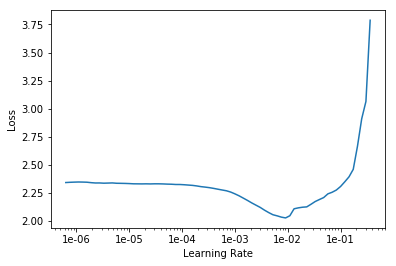

In [20]:
learn.lr_find()
learn.recorder.plot()

In [22]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-2, wd=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.047810,1.799288,0.747500,00:41
1,1.116593,2.434553,0.106250,00:42
2,1.104239,2.625396,0.199750,00:41
3,1.016882,2.432413,0.395000,00:41
4,0.962051,0.958914,0.819250,00:43
5,0.893754,0.565870,0.995500,00:45
6,0.849704,0.531021,0.995500,00:43
7,0.790922,0.513907,0.998500,00:43
8,0.756728,0.506403,0.999000,00:45
9,0.739415,0.505347,0.998750,00:44


In [24]:
preds, y, losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

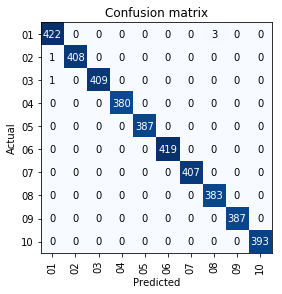

In [25]:
interp.plot_confusion_matrix()

# Trying tricks

In [32]:
from torch.optim import *

In [42]:
data = (
    (
        ImageList.from_folder(path)
        .split_by_rand_pct()
        .label_from_func(lab)
        .transform(get_transforms(), size=64)
    )
    .databunch(bs=256)
    .normalize(imagenet_stats)
)

In [41]:
learn = None
gc.collect()

20031

In [43]:
learn = Learner(data, arch, loss_func=loss_func, metrics=accuracy,).to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


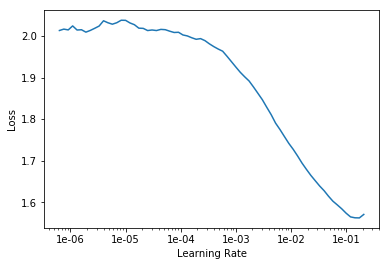

In [44]:
learn.lr_find()
learn.recorder.plot()

In [45]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-1, wd=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.046858,1.928354,0.552250,00:27
1,1.242287,nan,0.098750,00:26
2,1.331680,nan,0.098750,00:26
3,1.238398,nan,0.098750,00:25
4,1.121934,6.041868,0.099750,00:25
5,1.039799,3.904025,0.146750,00:25
6,0.978436,1.133655,0.782500,00:27
7,0.926404,0.761011,0.936000,00:25
8,0.884365,0.528519,0.998250,00:25
9,0.855049,0.514432,0.998500,00:26


In [46]:
preds, y, losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

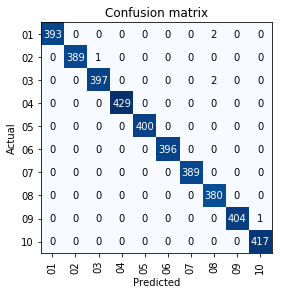

In [47]:
interp.plot_confusion_matrix()